In [1]:
import pandas
import numpy as np
import uproot
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import gc
from scipy import interpolate

In [2]:
def ReadBrancesToDataFrame(file_name, tree_name, branches, entrystart=None, entrystop=None):
    with uproot.open(file_name) as file:
        tree = file[tree_name]
        df = tree.arrays(branches, entrystart=entrystart, entrystop=entrystop, outputtype=pandas.DataFrame)
        df.columns = [ c.decode('utf-8') for c in df.columns ]
    return df

In [19]:
folder='./v1_val/'
branches = ['pt', 'eta', 'dz', 'dxy', 'decayModeFinding', 'decayMode', 'gen_tau', 'gen_jet', 'deepId_tau_vs_jet', 'refId_jet*',
            'otherId_tau_vs_all']
#df = ReadBrancesToDataFrame(folder + 'GluGluHToTauTau_M125.root', 'taus', branches)
df = ReadBrancesToDataFrame(folder + 'ZprimeToTauTau_M-2500.root', 'taus', branches)
df_taus = df[df['gen_tau'] == 1].copy(deep=True)
del df
gc.collect()
df_taus.columns

Index(['pt', 'eta', 'dz', 'dxy', 'decayModeFinding', 'decayMode', 'gen_tau',
       'gen_jet', 'deepId_tau_vs_jet', 'refId_jet', 'refId_jet_dR0p32017v2',
       'refId_jet_newDM2017v2', 'otherId_tau_vs_all'],
      dtype='object')

In [20]:
df = ReadBrancesToDataFrame(folder + 'QCD_Pt-15to7000_TuneCUETP8M1_Flat.root', 'taus', branches)
df_qcd = df[df['gen_jet'] == 1].copy(deep=True)
del df
gc.collect()

677

In [21]:
df = df_qcd.append(df_taus)
del df_taus
gc.collect()

0

In [12]:
def create_roc_ratio(x1, y1, x2, y2):
    idx_min = np.argmax((x2 >= x1[0]) & (y2 > 0))
    if x2[-1] <= x1[-1]:
        idx_max = x2.shape[0]
    else:
         idx_max = np.argmax(x2 > x1[-1])
    sp = interpolate.interp1d(x1, y1)
    x1_upd = x2[idx_min:idx_max]
    y1_upd = sp(x1_upd)
    return x1_upd, y1_upd / y2[idx_min:idx_max]

In [13]:
def ExcludeBadDM(df):
    br_to_fix = ['refId_jet', 'refId_jet_dR0p32017v2', 'refId_jet_newDM2017v2', 'otherId_tau_vs_all',
                 'deepId_tau_vs_jet']
    dm56 = (df['decayMode'] == 5) | (df['decayMode'] == 6)
    for branch_name in br_to_fix:
        fixed_br = branch_name + '_no56'
        df[fixed_br] = pandas.Series(df[branch_name], index=df.index)
        df.loc[dm56, fixed_br] = -10

In [14]:
def CreateROCs(df, tauIDs, pt_ranges, exclude_DM56):
    discr_name_suffix = ''
    if exclude_DM56:
        discr_name_suffix = '_no56'
        
    names = [ tauId['name'] for tauId in tauIDs ]
    for pt_range in pt_ranges:
        df_tj = df[(df['pt'] > pt_range[0]) & (df['pt'] < pt_range[1]) & (np.abs(df['eta']) < 2.3) \
                  & (np.abs(df['dz']) < 0.2)]
        
        fpr = [[None, None] for n in range(len(tauIDs))]
        tpr = [[None, None] for n in range(len(tauIDs))]
        
        for n in reversed(range(len(tauIDs))):
            fpr[n][0], tpr[n][0], thresholds = metrics.roc_curve(df_tj['gen_tau'],
                                                                 df_tj[tauIDs[n]['discr'] + discr_name_suffix])
            if n != len(tauIDs) - 1:
                tpr[n][1], fpr[n][1] = create_roc_ratio(tpr[n][0], fpr[n][0], tpr[-1][0], fpr[-1][0])
            
        fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(7,6), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
        for n in range(len(tauIDs)):
            ax.semilogy(tpr[n][0], fpr[n][0], color=tauIDs[n]['color'])
            if tpr[n][1] is not None:
                ax_ratio.plot(tpr[n][1], fpr[n][1], color=tauIDs[n]['color'], linewidth=1)
        
        #plt.ylim([0,0.2])
        #plt.xlim([.4, 0.8])
        ax_ratio.set_ylim([0, 3.5])
        ax.set_ylabel('Jet mis-id probability', fontsize=16)
        ax_ratio.set_xlabel('Tau ID efficiency', fontsize=16)
        ax_ratio.set_ylabel('id/deepId', fontsize=14)
        ax.tick_params(labelsize=14)
        ax_ratio.tick_params(labelsize=10)

        ax.grid(True)
        ax_ratio.grid(True)

        ax.legend(names, fontsize=14, loc='lower right')

        plt.subplots_adjust(hspace=0)
        plt.show()
        fig.savefig('tau_vs_jet{}_dzCut_pt-{}_{}.pdf'.format(discr_name_suffix, pt_range[0], pt_range[1]),
                    bbox_inches='tight')

In [24]:
ExcludeBadDM(df)

In [16]:
tauIDs = [
    { 'name': 'MVAIso 2017v2', 'discr': 'refId_jet', 'color': 'magenta' },
    { 'name': 'MVAIso newDM2017v2', 'discr': 'refId_jet_newDM2017v2', 'color': 'blue' },
    { 'name': 'DPF', 'discr': 'otherId_tau_vs_all', 'color': 'yellow' },
    { 'name': 'deepTau', 'discr': 'deepId_tau_vs_jet', 'color': 'red' }
]

In [22]:
#pt_ranges = [ [20, 30], [30, 40], [40, 50], [50, 70], [70, 100], [100, 150] ]
pt_ranges = [ [150, 200], [200, 300], [300, 500], [500, 700], [700, 1000] ]

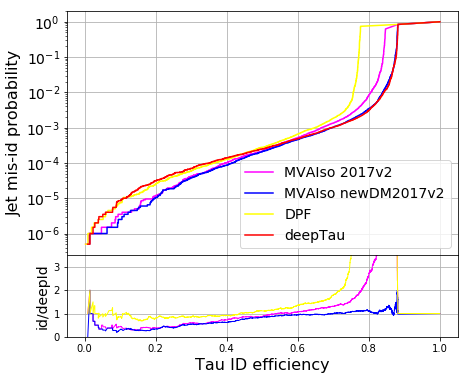

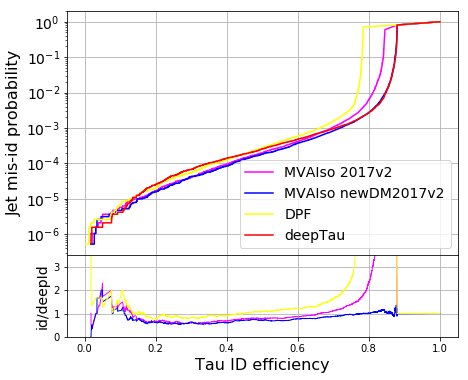

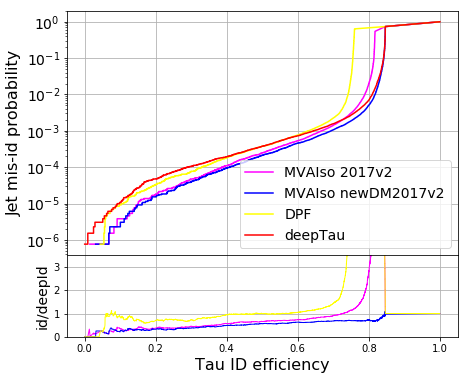

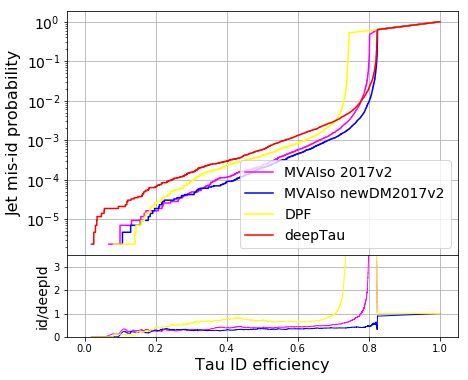

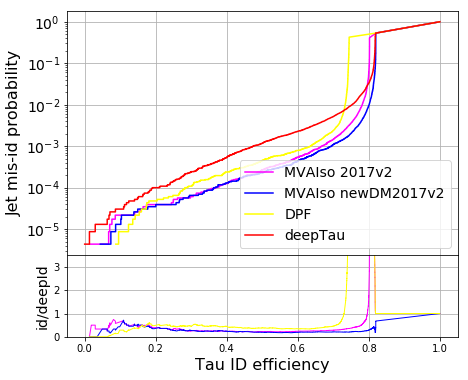

In [25]:
CreateROCs(df, tauIDs, pt_ranges, True)